# IRT Parameter Estimation


Deps
- numpy
- scipy
- matplotlib

## Item Characteristic Curve 

Here, a test-item is modeled with a three parameter logistic model. The test item's parameters are the following:

- a = 10 (discrimination - ability of question to split population accurately)
- b = 0.6 (difficulty - point at which persons with that ability level socre in the top 50th percentile)
- c = 0.25 (guessing parameter - probability that low-ability people can get the item correct)

The characteristics of the MC question are the following:

- has four equally interesting choices
- is slightly harder than average
- discriminates between novices and experts very well

The 3PL model allows us to determine the likelihood that a user at any given ability level will answer the question correctly.


- Probability: $ p(\theta) = c + (1 - c)\frac{\exp[a(\theta - b)]}{1 + \exp[a(\theta - b)]}$




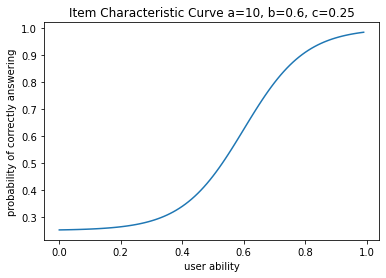

In [1]:
import sys
from irt_estimation.IIIPL import IIIPL
import numpy as np
import matplotlib.pyplot as plt

# Define test-item parameters
a = 10
b = 0.6
c = 0.25

# Instantiate 3PL model for test-item
item_model = IIIPL(a, b, c)

# Sample a uniform distribution of ability parameter vaules [0, 1] to draw the Item Characteristic Curve
theta = np.arange(0, 1, 0.01)
prob_correct = item_model.prob_correct_arr(theta)
plt.plot(theta, prob_correct)
plt.xlabel("user ability")
plt.ylabel("probability of correctly answering")
_ = plt.title(f"Item Characteristic Curve a={a}, b={b}, c={c}")

## Estimating an Examinee's Ability

To estimate an examinee's unknown ability parameter, it will be assumed that the numerical values of the
parameters of the test items are known. Additionally, the initial guess of the examinee's ability parameter will be some a priori value (e.g. $\theta = 1$).

Two methods for estimating an examinee's ability will be demonstrated
1. Maximum Likelihood Estimation
2. Maximum a Posteriori Estimation

### Maximum Likelihood Estimation 

Consider a K item test where the items are scored $u_j=0$ or $u_j=1$ depending if the answer is incorrect or correct for $j=1,...,K$. Assuming local independence of test items in the response vector $u=(u_1,...,u_K)$, the maximum likelihood estimator for an examinee's ability parameter $\theta$ is modeled with:


max: $L(\theta|u) = p(u|\theta) = \prod_{j = 1}^{K} p_j(\theta)^{u_j}[1-p_j(\theta)]^{1-u_j}$



--> ESTIMATE 0.6247470816562812


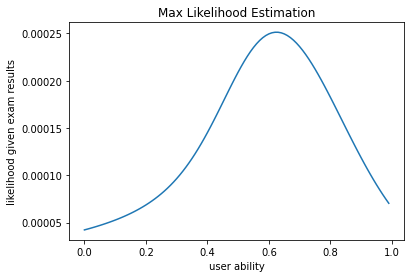

In [15]:
from irt_estimation.IIIPL import MLE_Ability_Estimator

# Exam results
answers = [
        (1, IIIPL(10, .5, .25)),
        (0, IIIPL(4, .4, .25)),
        (1, IIIPL(6, .8, .25)),
        (1, IIIPL(6, .9, .25)),
        (1, IIIPL(3, .2, .25)),
        (0, IIIPL(6, .4, .25)),
        (1, IIIPL(4, .3, .25)),
        (1, IIIPL(7, .5, .25))
]

# Instantiate estimator
estimator = MLE_Ability_Estimator(answers)


# Sample a uniform distribution of ability parameter vaules [0, 1] to draw Likelihood function
theta = np.arange(0, 1, 0.01)
likelihoods = estimator.likelihood_arr(theta)
plt.plot(theta, likelihoods)
plt.xlabel("user ability")
plt.ylabel("likelihood given exam results")
_ = plt.title(f"Max Likelihood Estimation")

# Estimate the user's ability parameter by maximizing the likelihood function
estimate = estimator.estimate()
print('--> ESTIMATE', estimate.x)

### Maximum a Posteriori Estimation

This estimation method is identical to the previous one except the likelihood function is multiplied by the ability paremeter's distribution. The equation for the posterior distribution of $\theta$ is the following:

- $p(\theta|u) = \frac{p(u|\theta)p(\theta)}{p(u)}$

Because the denominator is not a function of $\theta$, it has no bearing on the optimization and hence can be ignored. Is is sufficient to find the value of $\theta$ that maximizes numerator, giving:

- max $p(u|\theta)p(\theta)$

--> ESTIMATE 0.5609309959420644


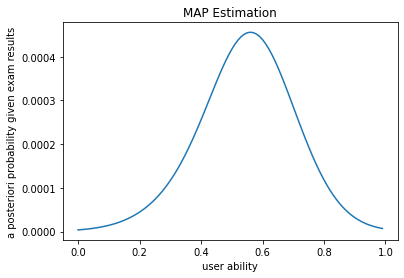

In [16]:
from irt_estimation.IIIPL import MAP_Ability_Estimator
from scipy.stats import norm

# Exam results
answers = [
        (1, IIIPL(10, .5, .25)),
        (0, IIIPL(4, .4, .25)),
        (1, IIIPL(6, .8, .25)),
        (1, IIIPL(6, .9, .25)),
        (1, IIIPL(3, .2, .25)),
        (0, IIIPL(6, .4, .25)),
        (1, IIIPL(4, .3, .25)),
        (1, IIIPL(7, .5, .25))
]

# Define ability parameter distribution of population
mean = 0.5
sd = 0.2
dist = norm(mean, sd)

# Instantiate estimator, set prior distribution
estimator = MAP_Ability_Estimator(answers, theta_dist=dist)

# Sample a uniform distribution of ability parameter vaules [0, 1] to draw MAP function
theta = np.arange(0, 1, 0.01)
likelihoods = estimator.likelihood_arr(theta)
plt.plot(theta, likelihoods)
plt.xlabel("user ability")
plt.ylabel("a posteriori probability given exam results")
_ = plt.title(f"MAP Estimation")

# Estimate the user's ability parameter by maximizing the MAP function
estimate = estimator.estimate()
print('--> ESTIMATE', estimate.x)